# Moiré bands of TMD hetero-bilayers

We want to evaluate the band structure and the arpes weights of WS2/WSe2 heterobilayer using a three-orbital model, Moiré potentials and spin-orbit coupling.

Let's start by importing the needed **libraries**.

Requirements: install *numpy*, *scipy*, *matplotlib* and *tqdm*.

Need to have the script *functions.py* in the same folder as this notebook. Also, remember to create a folder named *Figures* and one named *Data*.

In [41]:
import functions as fs      #usefull functions we will need
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import tqdm                 #for progres bars
import scipy.linalg as la    
from time import time as tt

## Input parameters:

-*N* is the number of circles of mini Brillouin zones considered around the central one. This parameter highly influences the duration of the calculation since the size of the Hamiltonian will be $18N^2+18N+6$. (N=0 is just the central one. Cannot see the difference after N=6)

-*lower/upper layer* defines what material is used for the bilayer. Order can be important if we include a "shading" factor

-*Path* defines the cut in the BZ that we want to consider. A legend of high symmetry points is: K-> K-point, G-> $\Gamma$-point, C-> $K'$-point, M->M-point, etc.. (full list is defined in dic_sym)

-*pts_ps* defines how many k-points to take in each step of the BZ cut. To make the final plot more accurate can be increased, but it takes more time

-*method* is either GGA or LDA, to follow the parameters of https://journals.aps.org/prb/abstract/10.1103/PhysRevB.88.085433

-*offset_energy* is the energy shift (in eV) between the two layers of TMD. It is applyed (subtracted) to the lower layer

In [53]:
N_circles = 6                               #Number of layers of small BZs to consider around the central one. N=0 i
upper_layer = 'WSe2'
lower_layer = 'WS2'
Path = 'KGC'               #Points of path in k-space. The dictionary is in dic_sym below
pts_ps = 200               #points in k-space to consider per-step
method = 'GGA'             #method used to evaluate the paramters
#dic_sym = {'G':r'$\Gamma$', 'K':'K', 'Q':r'$K/2$', 'q':r'$-K/2$', 'M':r'$M$', 'm':r'$-M$', 'N':r'$M/2$', 'n':r'$-M/2$', 'C':r'$K^\prime$', 'P':r'$K^\prime/2$', 'p':r'$-K^\prime/2$'}
dic_sym = {'G':'\Gamma', 'K':'K', 'Q':'K/2', 'q':'-K/2', 'M':'M', 'm':'-M', 'N':'M/2', 'n':'-M/2', 'C':'K^\prime', 'P':'K^\prime/2', 'p':'-K^\prime/2'}

Here I put some **model parameters** taken from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.88.085433 and other papers which are referred.

In [54]:
offset_energy = -0.41       #in eV. Offset between the two layers energies

#Table III of https://journals.aps.org/prb/abstract/10.1103/PhysRevB.88.085433.
#(first two in Angstrom, all others in eV, last is the lambda of SO-> from table IV)
dic_params_H = {'GGA':{
                    'WS2':[3.191,3.144,0.717, 1.916, -0.152, -0.097, 0.590, 0.047, 0.178, 0.016, 0.069, -0.261, 0.107, -0.003, 0.109, -0.054, 0.045, 0.002, 0.325, -0.206, -0.163, 0.211],
                    'WSe2':[3.325, 3.363, 0.728, 1.655, -0.146, -0.124, 0.507, 0.117, 0.127, 0.015, 0.036, -0.234, 0.107, 0.044, 0.075, -0.061, 0.032, 0.007, 0.329, -0.202, -0.164, 0.228],
                    'WTe2':[3.560, 3.632, 0.697, 1.380, -0.109, -0.164, 0.368, 0.204, 0.093, 0.038, -0.015, -0.209, 0.107, 0.115, 0.009, -0.066, 0.011, -0.013, 0.312, -0.177, -0.132, 0.237],
                    'MoS2':[3.190, 3.130, 0.683, 1.707, -0.146, -0.114, 0.506, 0.085, 0.162, 0.073, 0.060, -0.236, 0.067, 0.016, 0.087, -0.038, 0.046, 0.001, 0.266, -0.176, -0.150, 0.073],
                    'MoSe2':[3.326, 3.345,  0.684, 1.546, -0.146, -0.130, 0.432, 0.144, 0.117, 0.075, 0.039, -0.209, 0.069, 0.052, 0.060, -0.042, 0.036, 0.008, 0.272, -0.172, -0.150, 0.091],
                    'MoTe2':[3.557, 3.620,  0.588, 1.303, -0.226, -0.234, 0.036, 0.400, 0.098, 0.017, 0.003, -0.025, -0.169, 0.082, 0.051, 0.057, 0.103, 0.187, -0.045, -0.141, 0.087, 0.107]
                    },
                'LDA':{
                    'WS2':[3.132, 3.126, 0.905, 2.167, -0.175, -0.090, 0.611, 0.043, 0.181, 0.008, 0.075, -0.282, 0.127, 0.001, 0.114, -0.063, 0.047, 0.004, 0.374, -0.224, -0.177, 0.211],
                    'WSe2':[3.253, 3.338, 0.860, 1.892, -0.152, -0.125, 0.508, 0.094, 0.129, 0.009, 0.044, -0.278, 0.129, 0.059, 0.058, -0.090, 0.039, 0.001, 0.392, -0.224, -0.165, 0.228],
                    'WTe2':[3.476, 3.611, 0.675, 1.489, -0.124, -0.159, 0.362, 0.196, 0.101, 0.044, -0.009, -0.250, 0.129, 0.131, -0.007, -0.086, 0.012, -0.020, 0.361, -0.193, -0.129, 0.237],
                    'MoS2':[3.129, 3.115, 0.820, 1.931, -0.176, -0.101, 0.531, 0.084, 0.169, 0.070, 0.070, -0.252, 0.084, 0.019, 0.093, -0.043, 0.047, 0.005, 0.304, -0.192, -0.162, 0.073],
                    'MoSe2':[3.254, 3.322, 0.715, 1.687, -0.154, -0.134, 0.437, 0.124, 0.119, 0.072, 0.048, -0.248, 0.090, 0.066, 0.045, -0.067, 0.041, 0.005, 0.327, -0.194, -0.151, 0.091],
                    'MoTe2':[3.472, 3.598, 0.574, 1.410, -0.148, -0.173, 0.333, 0.203, 0.186, 0.127, 0.007, -0.280, 0.067, 0.073, 0.081, -0.054, 0.008, 0.037, 0.145, -0.078, 0.035, 0.107]
                    }
                }

###Moirè potentials of bilayers. Different at Gamma (d_z^2 orbital) -> first two parameters, and K (d_xy orbitals) -> last two parameters
#WS2/WSe2 --> Gamma points from https://www.pnas.org/doi/10.1073/pnas.2021826118 (first in eV, second in radiants)
#WS2/WSe2 --> K points from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.105.195428 (first in eV, second in radiants)
dic_params_V = {'WSe2/WS2':[0.0335,np.pi, 7.7*1e-3, -106*2*np.pi/360],
                'WS2/WSe2':[0.0335,np.pi, 7.7*1e-3, -106*2*np.pi/360],     #here just took the same as above
            }

###Moirè length of bilayers in Angstrom
dic_a_M = { 'WS2/WSe2':79.8,
            'WSe2/WS2':79.8,
       }


## Band calculation

First of all, we determine the k-points in the BZ that we want to compute. In order to do so we evaluate the reciprocal lattice vectors. Then, we define the high symmetry points and take the path defined above to put all the k-points in a list

In [55]:
params_H =  [dic_params_H[method][upper_layer], dic_params_H[method][lower_layer]]                 #Hamiltonian parameters
params_V =  [dic_params_V[upper_layer+'/'+lower_layer], 
             dic_params_V[lower_layer+'/'+upper_layer]] #Moiré potential parameters
a_M =       dic_a_M[upper_layer+'/'+lower_layer]                 #Moiré length

#Reciprocal lattice vectors with lattice length 'a_monolayer'. 
#Starts from G[0] along y and goes counter-clockwise with R_6 rotations.
a_monolayer = params_H[0][0]          #lattice constant of UPPER layer
reciprocal_lattice_vector = [4*np.pi/np.sqrt(3)/a_monolayer*np.array([0,1])]      
for i in range(1,6):
    reciprocal_lattice_vector.append(np.tensordot(fs.R_z(np.pi/3*i),reciprocal_lattice_vector[0],1))
#Now, I define the symmetry points
K = np.array([reciprocal_lattice_vector[-1][0]/3*2,0])     #K-point
Gamma = np.array([0,0])                                    #Gamma
K2 =    K/2                                                #Half is denoted by a '2'
K2_ =   - K2                                               #Opposite wrt G is denoted by '_'
M =     reciprocal_lattice_vector[-1]/2                    #M-point
M_ =     - M
M2 =    M/2 
M2_ =   - M2
Kp =    np.tensordot(fs.R_z(np.pi/3),K,1)                  #K'-point
Kp_ = - Kp
Kp2 =   Kp/2
Kp2_ =   -Kp2
dic_names = {'G':Gamma,'K':K,'M':M,'m':M_,'C':Kp,'c':Kp_,'Q':K2,'q':K2_,'N':M2,'n':M2_,'P':Kp2,'p':Kp2_}
path = []
for i in range(len([*Path])-1):
    Pi = dic_names[Path[i]]
    Pf = dic_names[Path[i+1]]
    direction = Pf-Pi
    for i in range(pts_ps):
        path.append(Pi+direction*i/pts_ps)
K_points = []
for i in [*Path]:
    K_points.append(dic_names[i])

Now we compute the energy spectrum and the arpes weights. We also save the data so that we can use it again to re-do the plots.

In [9]:
#File_names. Maybe can be changed to be more specific on which bands we are computing
data_name = "Data/energies_"+upper_layer+"-"+lower_layer+"_"+str(N_circles)+'_'+Path+'_'+str(pts_ps)+".npy"
weights_name = "Data/weights_"+upper_layer+"-"+lower_layer+"_"+str(N_circles)+'_'+Path+'_'+str(pts_ps)+".npy"
try:    #try to upload the data if it has already been computed
    energies = np.load(data_name)
    weights = np.load(weights_name)
    print("\nBands and ARPES weights already computed")
except:   #actual band computation
    print("Computing bilayer energies and ARPES weights ...")
    ti = tt()
    n_cells = int(1+3*N_circles*(N_circles+1))*2        #dimension of H divided by 3 -> take only valence bands
    #select_by_value for the diagonalization -> takes only valence bands. 
    #This is an energy interval (in eV) where we accept the result so that we don't have to look for the whole spectrum. It saves some computation time
    sbv = [-4,0.5]                      
    energies = np.zeros((2,len(path),n_cells))    #dimesion given by: 2->layers, len(path)->k-points, n_cells->number of eigenvalues computed
    weights = np.zeros((2,len(path),n_cells))
    for i in tqdm.tqdm(range(len(path))):         #loop over k-points in the path
        K_temp = path[i]
        #since there is no interlayer hopping we can diagonalize separately the two single-layer Hamiltonians
        H_UL = fs.total_H(K_temp,N_circles,params_H[0],params_V[0],a_M)     #Compute Hamiltonian for given K of upper layer
        H_LL = fs.total_H(K_temp,N_circles,params_H[1],params_V[1],a_M)     #Compute Hamiltonian for given K of lower layer
        energies[0,i,:],evecs_UL = la.eigh(H_UL,subset_by_value=sbv)
        energies[1,i,:],evecs_LL = la.eigh(H_LL,subset_by_value=sbv)           #Diagonalize to get eigenvalues and eigenvectors        evecs = [evecs_LL,evecs_UL]          #just group the eigenvectors in a list
        evecs = [evecs_UL,evecs_LL]
        for l in range(2):     #loop over the layers
            for e in range(n_cells):    #loop over the bands
                for d in range(6):      #loop over the six dimensions of the three-band model with spin orbit coupling
                    weights[l,i,e] += np.abs(evecs[l][d,e])**2
    energies[1] -= offset_energy        #offset the lower layer energy
    #np.save(data_name,energies)         #save for future use
    #np.save(weights_name,weights)
    print("Time taken: ",tt()-ti," seconds")

Computing bilayer energies and ARPES weights ...


100%|█████████████████████████████████████████| 200/200 [00:37<00:00,  5.40it/s]

Time taken:  37.07698726654053  seconds


## Monolayers
Here we compute the two monolayer bandstructures to compare them on the final plot.

In [56]:
params_V = [0,0,0,0]    #no Moirè potential
#########Upper-layer bands
res_mono_UL = np.zeros((len(path),6))
for i in tqdm.tqdm(range(len(path))):
    K = path[i]
    H_k = fs.total_H(K,0,params_H[0],params_V,a_M)     #the only difference is in N which now is 0
    res_mono_UL[i,:],evecs_mono_UL = np.linalg.eigh(H_k)
#########Lower-layer bands
res_mono_LL = np.zeros((len(path),6))
for i in tqdm.tqdm(range(len(path))):
    K = path[i]
    H_k = fs.total_H(K,0,params_H[1],params_V,a_M)     #the only difference is in N which now is 0
    res_mono_LL[i,:],evecs_mono_LL = np.linalg.eigh(H_k)

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 5650.82it/s]


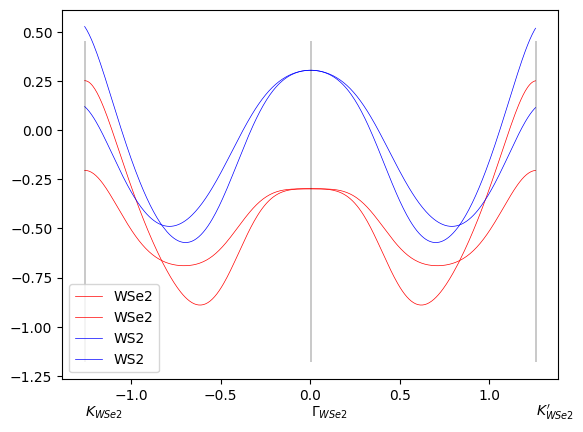

In [57]:
Ki, Km, Kf = K_points
lp = len(path)
K_list = np.linspace(-np.linalg.norm(Ki-Km),np.linalg.norm(Kf-Km),lp)
#
for b in range(2):      #plot valence bands (2 for spin-rbit) of upper-monolayer   RED
    plt.plot(K_list,res_mono_UL[:,b],'r-',lw = 0.5,label=upper_layer)
for b in range(2):      #plot valence bands (2 for spin-rbit) of lower-monolayer   BLUE
    plt.plot(K_list,res_mono_LL[:,b]-offset_energy,'b-',lw = 0.5, label=lower_layer)
plt.legend()
Min_E = np.amin(res_mono_UL[:,:2].ravel()) - 0.2 if np.amin(res_mono_UL[:,:2].ravel())<np.amin(res_mono_LL[:,:2].ravel()) else np.amin(res_mono_LL[:,:2].ravel()) - 0.2
Max_E = np.amax(res_mono_UL[:,:2].ravel()) + 0.2 if np.amax(res_mono_UL[:,:2].ravel())>np.amax(res_mono_LL[:,:2].ravel()) else np.amax(res_mono_LL[:,:2].ravel()) + 0.2
Delta = Max_E-Min_E
for i,c in enumerate([*Path]):      #plot symmetry points as vertical lines
    a = 1 if i == 2 else 0
    plt.vlines(K_list[i*lp//2-a],Min_E,Max_E,'k',lw=0.3,label=c)
    text_UL = r'$'+dic_sym[c]+'_{'+upper_layer+'}$'
    plt.text(K_list[i*lp//2-a],Min_E-Delta/6,text_UL)

## False color plot

We are ready to construct the false color plot of the arpes weights. The parameters to chose here are:

-*gridy* is the number of points to consider in the energy scale when plotting in false color. It is by default initialized to the number of k-points in the path but can be changed to make the plot more or less accurate

-*K_* and *E_* are the Lorentzian spreads in momentum and energy respectively

-*larger_E* tells how much above (below) to go over (under) the maximum (minimum) band energy. It essentially makes the plot larger in the energy direction.

-*shade_lower_layer* if a factor from 0 to 1 multiplied to the lower layer 

In [21]:
#Inputs:
gridy = pts_ps*(len(Path)-1)          #when plotting the false color, we need to discretize the energy scale. 
K_ = 0.0004                            #spread in momentum
E_ = 0.005                             #spread in energy in eV
larger_E = 0.2                        #in eV. Enlargment of E axis wrt min and max band energies
shade_lower_layer = 0.3            #shading factor (0 to 1) of lower layer
#
bnds = len(energies[0,0,:])
lp = len(path);     gridx = lp;       #grid in momentum fixed by points evaluated in k-space
K2 = K_**2
E2 = E_**2
min_e = np.amin(np.ravel(energies[:,:,:]))
max_e = np.amax(np.ravel(energies[:,:,:]))
MIN_E = min_e - larger_E
MAX_E = max_e + larger_E
delta = MAX_E - MIN_E
step = delta/gridy
#K-axis
Ki, Km, Kf = K_points
K_list = np.linspace(-np.linalg.norm(Ki-Km),np.linalg.norm(Kf-Km),lp)
#E-axis
E_list = np.linspace(MIN_E,MAX_E,gridy)
#Compute values of lorentzian spread of weights
lor_name = "Data/FC_"+upper_layer+"-"+lower_layer+"_"+str(N_circles)+'_'+Path+'_'+str(pts_ps)
par_name = '_Full_('+str(gridy)+'_'+str(larger_E).replace('.',',')+'_'+str(K_).replace('.',',')+'_'+str(E_).replace('.',',')+')'+".npy"
lor_name += par_name
shade = [1,shade_lower_layer]
try:
    lor = np.load(lor_name)
    print("\nLorentzian spread already computed")
except:
    print("\nComputing Lorentzian spread ...")
    lor = np.zeros((lp,gridy))
    for l in range(2):
        for i in tqdm.tqdm(range(lp)):
            for j in range(bnds):
                pars = (K2,E2,weights[l,i,j],K_list[i],energies[l,i,j])
                lor += fs.lorentzian_weight(K_list[:,None],E_list[None,:],*pars)*shade[l]
    #np.save(lor_name,lor)


Computing Lorentzian spread ...


100%|█████████████████████████████████████████| 400/400 [00:47<00:00,  8.48it/s]


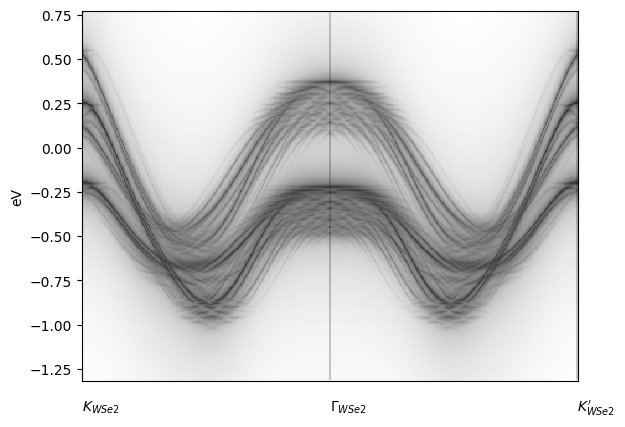

In [41]:
#whether to show (1) or not (0) the monolayer bands
monolayer_bands = 0  

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
if monolayer_bands:
    for b in range(2):      #plot valence bands (2 for spin-rbit) of upper-monolayer   RED
        plt.plot(K_list,res_mono_UL[:,b],'r-',lw = 0.5)
    for b in range(2):      #plot valence bands (2 for spin-rbit) of lower-monolayer   BLUE
        plt.plot(K_list,res_mono_LL[:,b]-offset_energy,'b-',lw = 0.5)
#
for i,c in enumerate([*Path]):      #plot symmetry points as vertical lines
    a = 1 if i == 2 else 0
    plt.vlines(K_list[i*lp//2-a],MIN_E,MAX_E,'k',lw=0.3,label=c)
    text_UL = r'$'+dic_sym[c]+'_{'+upper_layer+'}$'
    plt.text(K_list[i*lp//2-a],MIN_E-delta/12,text_UL)
#
X,Y = np.meshgrid(K_list,E_list)
plt.pcolormesh(X, Y,lor.T,alpha=0.8,cmap=plt.cm.Greys,norm=LogNorm(vmin=lor[np.nonzero(lor)].min(), vmax=lor.max()))
plt.ylabel('eV')
#plt.savefig("Figures/fig_"+str(N_circles))
plt.show()